# Glycolysis FBA, Elementary Modes, Thermodynamics

## Notebook setup

In [1]:
import ipywidgets as widgets
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from IPython.display import HTML, JSON, SVG, display

from mosmo.calc import fba_gd, elementary_modes, convenience_kinetics
from mosmo.knowledge import kb
from mosmo.knowledge.thermo import Thermodynamics
from mosmo.model import DS, DbXref, KbEntry, Molecule, Reaction, Pathway
from mosmo.preso.escher import escher_map

# Setup matplotlib to play nice with widgets
%matplotlib widget
plt.ioff()

# Setup jax to use float64, and get the No GPU warning out of the way
jax.config.update('jax_enable_x64', True)
# prng = jax.random.PRNGKey(int(time.time() * 1000))

# Setup KB and ΔG data access
KB = kb.configure_kb()
thermo = Thermodynamics(p_h=7.3, p_mg=1.5, ionic_strength=0.25, temperature=298.15)

## Pathway: glycolysis + PPP + Overflow
### Basic pathway composition

Pathway consists of 26 reactions on 35 metabolites



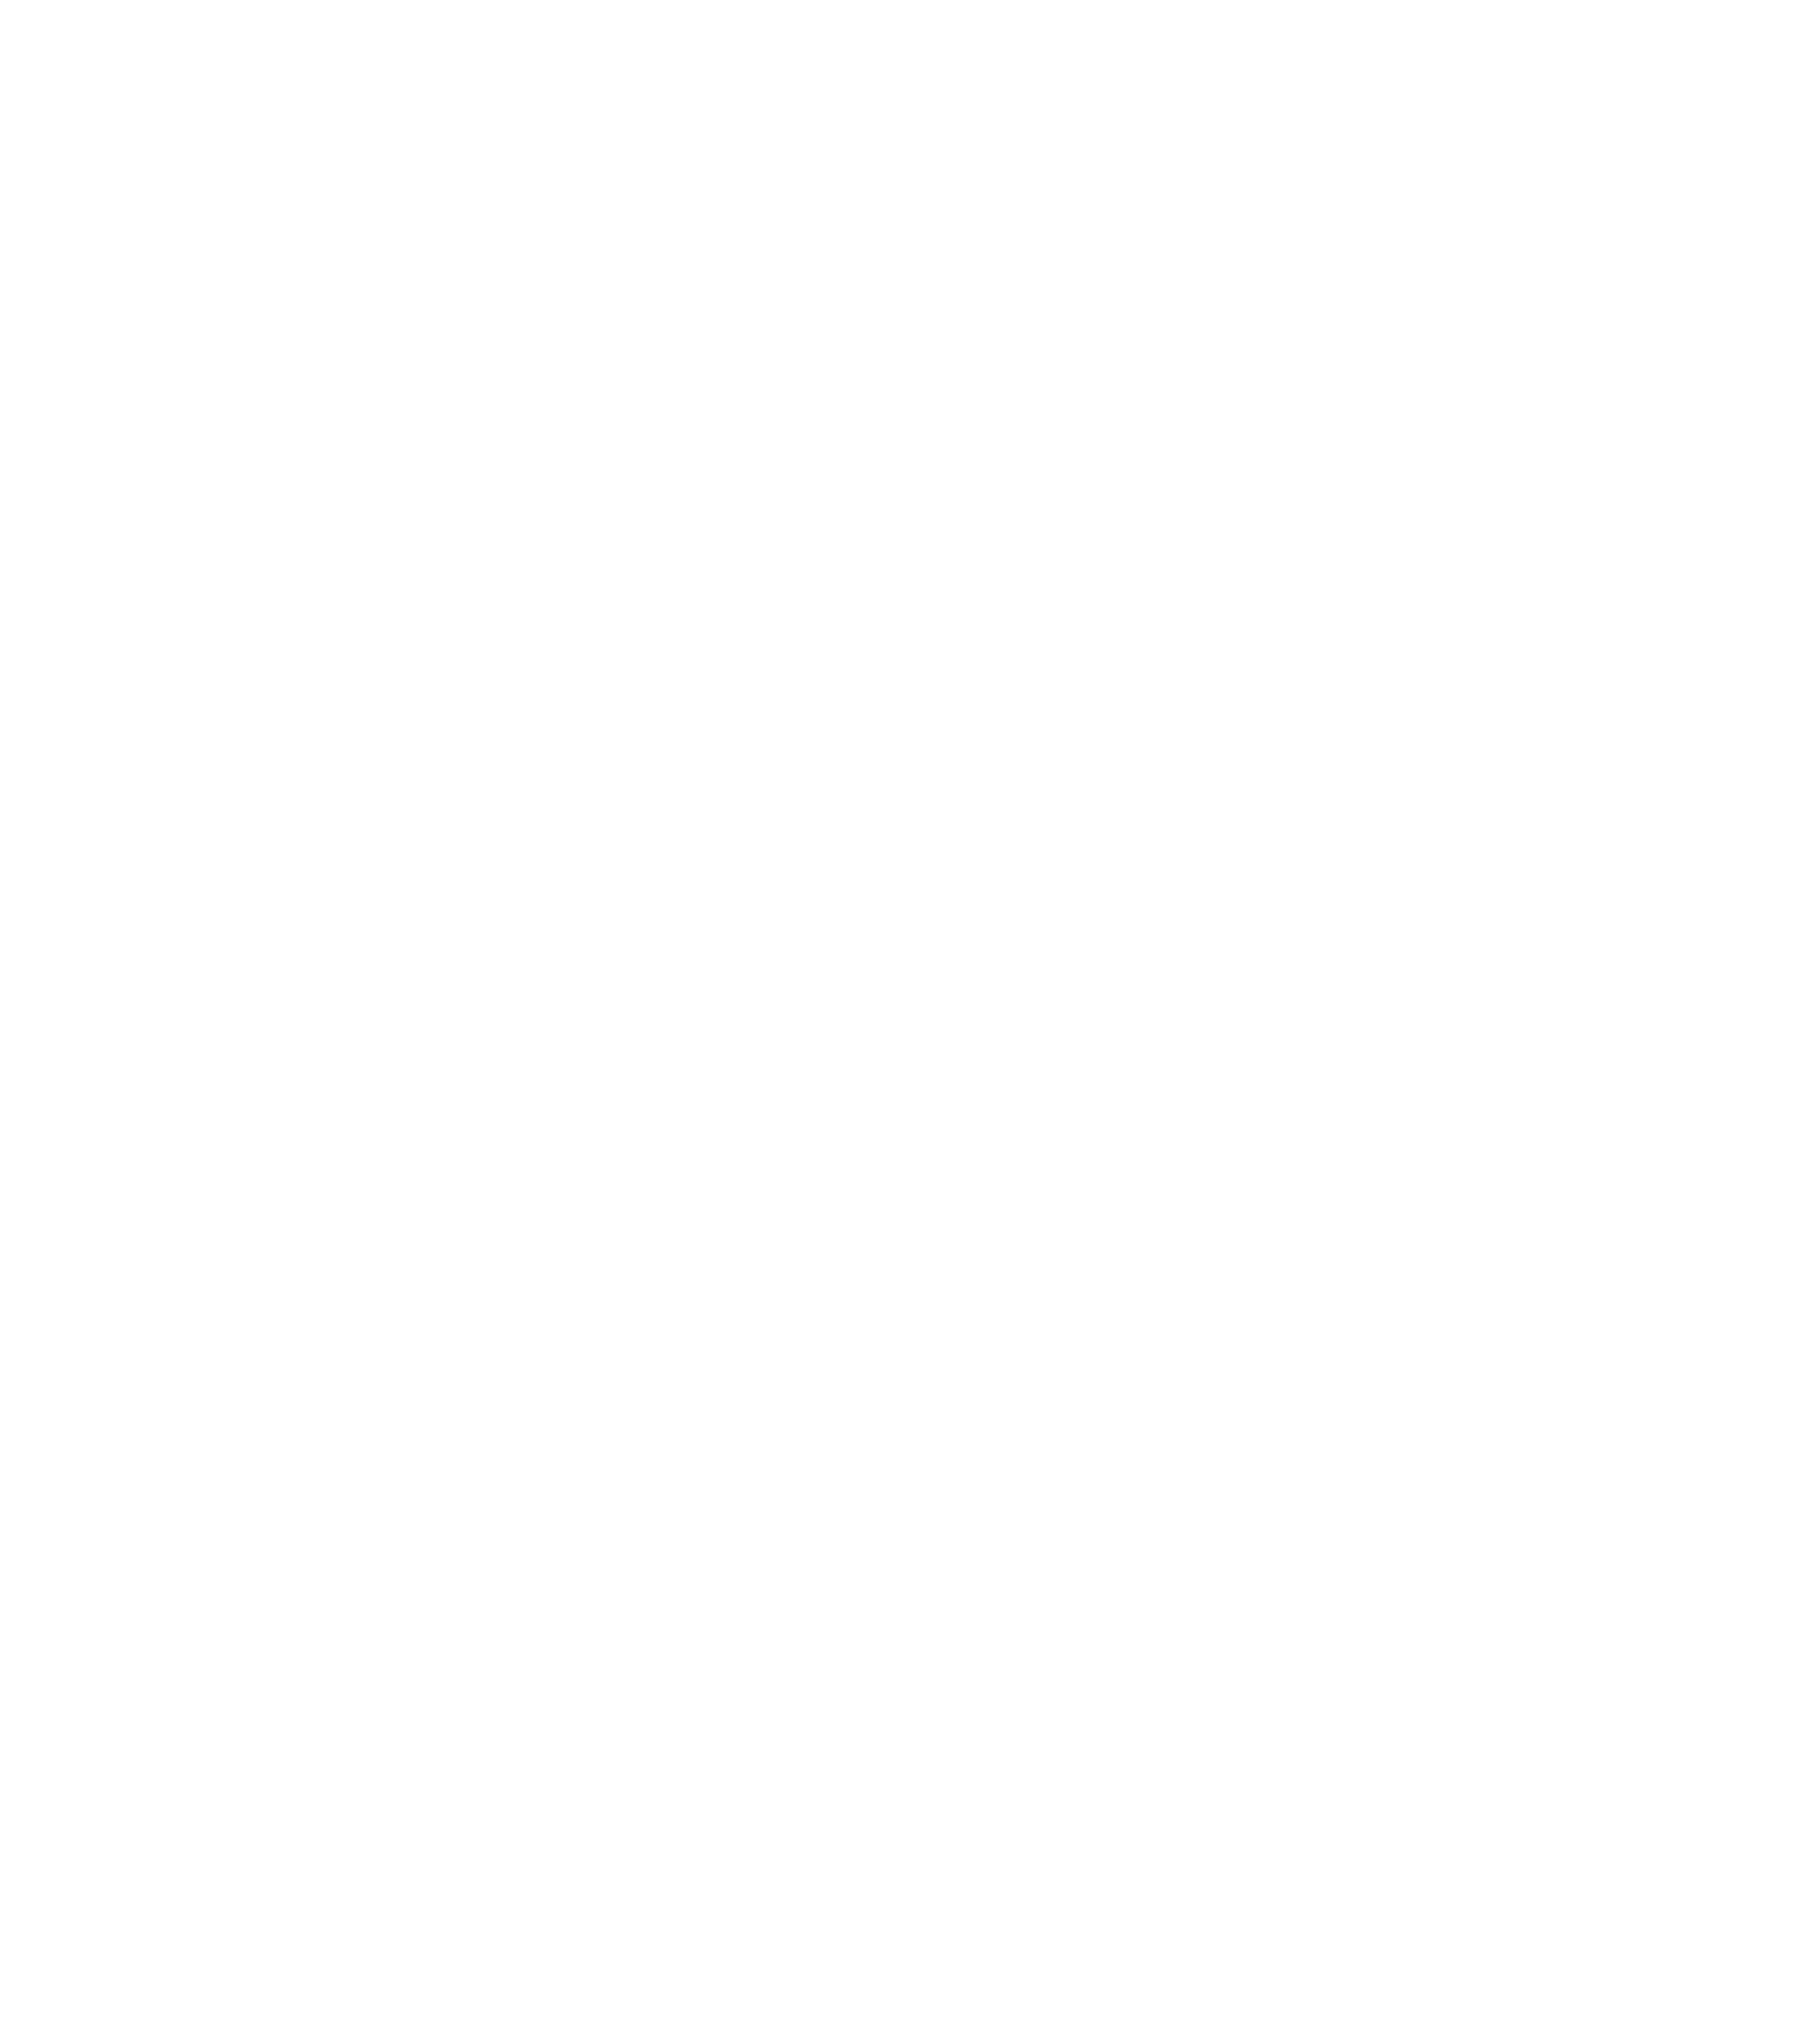

In [2]:
pw = KB('glycolysis_ppp_ov')
print(f"Pathway consists of {len(pw.reactions)} reactions on {len(pw.molecules)} metabolites")
print()
diag = escher_map.EscherMap(pw.diagram, width="6in")
SVG(diag.draw())

In [3]:
pd.DataFrame([
    {"Id" : met.id, "Name": met.name, "Formula": met.formula, "Mass": met.mass, "ΔG(f)": thermo.formation_delta_g(met)}
    for met in pw.molecules
],
).set_index("Id").sort_index()

,Name,Formula,Mass,ΔG(f)
Id,,,,
2pg,2-phospho-D-glycerate,C3H4O7P,183.03340,-1343.842495
3pg,3-phospho-D-glycerate,C3H4O7P,183.03340,-1346.828234
6pg,6-phosphogluconate,C6H10O10P,273.11140,-1550.150833
6pgdl,6-phosphogluconolactone,C6H9O9P,256.10400,-1371.109479
Ery.D.4P,D-erythrose 4-phosphate,C4H7O7P,198.06794,-1147.071037
Fru.D.6P,D-fructose 6-phosphate,C6H11O9P,258.11990,-1301.448512
Fru.D.bis16,"D-fructose 1,6-bisphosphate",C6H10O12P2,336.08390,-2195.339024
Glc.D.6P,D-glucose 6-phosphate,C6H11O9P,258.11990,-1301.398652
Glc.D.ext,D-glucose (external),C6H12O6,180.15588,-405.995392


In [4]:
pd.DataFrame([
    {"Id": rxn.id, "Name": rxn.name, "Catalyst": rxn.catalyst.id if rxn.catalyst else "", "Reaction": rxn.equation, "ΔG°": thermo.reaction_delta_g(rxn)}
    for rxn in pw.reactions
]).set_index("Id")

,Name,Catalyst,Reaction,ΔG°
Id,,,,
gapdh,Glyceraldehyde-3-phosphate Dehydrogenase,GapA,GAP + NAD+ + Pi <=> DPG + H+ + NADH,1.779918
pgk,Phosphoglycerate Kinase,Pgk,3PG + ATP <=> DPG + ADP,18.149293
gpm,Phosphoglycerate Mutase,GpmM,2PG <=> 3PG,-2.985739
eno,Enolase,Eno,2PG <=> H2O + PEP,-4.289953
pps,Phosphoenolpyruvate Synthetase,PpsA,ATP + H2O + pyr => AMP + Pi + PEP + 2 H+,-0.820985
pdh,Pyruvate Dehydrogenase,Pdh,CoA + NAD+ + pyr => acCoA + CO2 + NADH,-32.571998
pyk,Pyruvate Kinase,PykFA,ATP + pyr <=> ADP + H+ + PEP,27.234921
tpi,Triose-phosphate Isomerase,TpiA,GAP <=> DHAP,-6.580472
fba,Fructose-bisphosphate Aldolase,FbaAB,FDP <=> GAP + DHAP,28.116124


## Pathways in Action: Flux Balance Analysis (FBA)

#### InteractiveFba code

In [5]:
class InteractiveFba:
    def __init__(self, pw, boundaries, targets, additional_objectives=None):
        self.pw = pw
        self.boundaries = boundaries
        self.boundary_indices = np.array([pw.molecules.index_of(b) for b in boundaries])

        # Set up the controls and update logic
        self.control_map = {}
        for target, value in targets.items():
            control = widgets.FloatSlider(
                value=value,
                description=target.label,
                min=0,
                max=10.0,
                step=0.1,
                continuous_update=False,
                readout=True,
                readout_format=".1f")
            control.observe(self.update, names="value")
            self.control_map[control] = target
        
        # Boundary flux plot
        fig, ax = plt.subplots(figsize=(3, 4))
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False
        fig.canvas.toolbar_visible = False
        fig.canvas.resizable = False

        y = np.arange(len(boundaries))
        ax.set_title("Boundary Fluxes")
        ax.set_xlabel('Net Flux')
        ax.set_xlim(-10, 10)
        ax.set_yticks(y, labels=[b.label for b in boundaries])
        ax.invert_yaxis()
        ax.grid(True)
        ax.axvline(0)
        fig.tight_layout()
        
        self.boundary_plot = fig
        self.bars = ax.barh(y, width=0)

        # Pathway diagram to show reaction fluxes
        self.diagram = escher_map.EscherMap(
            pw.diagram,
            width="15cm",
            reaction_scale=escher_map.Scale({0: ("#eeeeee", 5), 10: ("#1f77b4", 40)}, use_abs=True),
            # metabolite_scale=escher_map.Scale({0: ("#eeeeee", 5), 10: ("#cb4154", 40)}, use_abs=True)
        )
        self.diag_canvas = widgets.Output()

        # Set up the FBA problem
        intermediates = [met for met in pw.molecules if met not in boundaries]
        objectives = {"targets": fba_gd.ProductionObjective(pw, targets)}
        if additional_objectives:
            objectives.update(additional_objectives)
        self.fba = fba_gd.FbaGd(pw, intermediates, objectives)
        # Draw everything with the initial solution before displaying it
        self.show_results(self.fba.solve())

        # Finally, lay it all out in a dashboard
        self.dashboard = widgets.HBox([
            widgets.VBox([
                widgets.VBox(list(self.control_map.keys())),
                fig.canvas,
            ], layout=widgets.Layout(width="40%")),
            self.diag_canvas,
        ], layout = widgets.Layout(width='1000px', border='1px solid green'))

    def show_results(self, soln):
        # Update the Boundary Fluxes plot
        for bar, value in zip(self.bars, soln.dmdt[self.boundary_indices]):
            bar.set_width(value)
        self.boundary_plot.canvas.draw_idle()

        # Update the pathway diagram
        svg = self.diagram.draw(reaction_data={rxn.id: flux for rxn, flux in pw.reactions.unpack(soln.velocities).items()})
        self.diag_canvas.clear_output(wait=True)
        with self.diag_canvas:
            display(SVG(svg))
        

    def update(self, change):
        if change.type == "change":
            self.fba.update_params({"targets": {self.control_map[change.owner]: change.new}})
            self.show_results(self.fba.solve())


#### Interactive FBA

In [6]:
boundaries = [KB(met_id) for met_id in ["Glc.D.ext", "Ery.D.4P", "Rib.D.5P", "accoa", "co2",
                                        "atp", "adp", "amp", "pi",
                                        "nad.ox", "nad.red", "nadp.ox", "nadp.red",
                                        "coa", "h+", "h2o"]]

InteractiveFba(
    pw,
    boundaries=boundaries,
    targets={KB("accoa"): 5, KB("Ery.D.4P"): 0, KB("Rib.D.5P"): 0,},
    additional_objectives = {'unused_reactions': fba_gd.VelocityObjective(pw, {KB('pgldhat'): 0})}
).dashboard


## Elementary Modes

#### Elementary Mode support code

In [7]:
def build_internal_system(pw, bounds):
    """Returns S matrix with rows for internal (non-bounds) metabolites only."""
    intermediates = [met not in bounds for met in pw.molecules]
    return pw.s_matrix[intermediates].astype(int)

def mode_formula(pw, mode):
    parts = []
    for reaction, coeff in zip(pw.reactions.labels(), mode):
        if coeff == -1:
            parts.append('-')
        elif coeff < 0:
            parts.append(f'- {-coeff}')
        elif coeff == 1:
            if parts:
                parts.append('+')
        elif coeff > 0:
            if parts:
                parts.append(f'+ {coeff}')
            else:
                parts.append(f'{coeff}')
        
        if coeff:
            parts.append(reaction)
    
    return ' '.join(parts)

def show_modes(pw, modes, rev):
    s_elementary = (pw.s_matrix.astype(int) @ modes)
    net_reactions = []
    for i, (mode, reversible) in enumerate(zip(s_elementary.T, rev)):
        stoich = {}
        for met, count in zip(pw.molecules, mode):
            if count != 0:
                stoich[met] = count

        net_reaction = Reaction(id=f'mode{i}', name=f'Elementary Mode {i}', stoichiometry=stoich, reversible=reversible)
        net_reactions.append(net_reaction)

    w = f'{160 + modes.shape[1] * 8:d}px' if modes.shape[1] < 80 else '100%'
    mode_select = widgets.IntSlider(
        value=0,
        min=0,
        max=modes.shape[1] - 1,
        description='Mode',
        continuous_update=True,
        readout=True,
        layout={'width': w}
    )
    mode_fluxes = widgets.Text(description='reactions', layout={'width': '99%'})
    mode_net = widgets.Text(description='net reaction', layout={'width': '99%'})
    diag = escher_map.EscherMap(
        pw.diagram,
        width="100%",
        reaction_scale=escher_map.Scale({0.: ("#eeeeee", 3), 6.: ("#1f77cc", 50)}, use_abs=True))
    diag_canvas = widgets.Output()

    def show_mode(change):
        mode = mode_select.value
        mode_fluxes.value = mode_formula(pw, modes.T[mode])
        mode_net.value = net_reactions[mode].equation
        diag_canvas.clear_output(wait=True)
        with diag_canvas:
            display(SVG(diag.draw(reaction_data={r.id: v for r, v in zip(pw.reactions, modes.T[mode])})))

    mode_select.observe(show_mode, names='value')
    show_mode(None)

    return widgets.VBox([
        mode_select,
        widgets.HBox([
            widgets.VBox([
                mode_fluxes,
                mode_net
            ], layout={"width": "40%"}),
            widgets.VBox([
                diag_canvas
            ], layout={"width": "60%"}),
        ])
    ], layout={"width": "1000px", "border": "1px solid green"})


#### Elementary Modes results

In [8]:
modes, rev = elementary_modes.elementary_modes(build_internal_system(pw, boundaries), [r.reversible for r in pw.reactions])
show_modes(pw, modes, rev)

## Thermodynamics, ΔG, and standard ΔG

In [9]:
# Concentrations in mM, taken (mostly) from Rabinowitz (2016)
concs = {KB(met_id): conc/1000 for met_id, conc in [
    ('2pg', 9.18e-02),
    ('6pg', 3.77),
    ('6pgdl', 1.), # Not provided; reasonable guess
    ('Ery.D.4P', 4.90e-02),
    ('Fru.D.6P', 2.52),
    ('Fru.D.bis16', 15.2),
    ('Glc.D.ext', 10.),  # Arbitrary; environment
    ('Glc.D.6P', 7.88),
    ('Rib.D.5P', 7.87e-01),
    ('Rul.D.5P', 1.12e-01),
    ('Sed.D.7P', 8.82e-01),
    ('Xul.D.5P', 1.81e-01),
    ('accoa', 6.06e-01),
    ('adp', 5.55e-01),
    ('amp', 2.81e-01),
    ('atp', 9.63),
    ('co2', 7.52e-02),
    ('coa', 1.37),
    ('dpg', 1.65e-02),
    ('nad.ox', 2.55),
    ('nad.red', 8.36e-02),
    ('nadp.ox', 2.08e-03),
    ('nadp.red', 1.21e-01),
    ('pep', 1.84e-01),
    ('pi', 23.9),
    ('pyr', 3.66),

    # Forcing H+ and water to activity = 1.0 excludes them from reaction quotient, to make calculations consistent with eQuilibrator.
    # ('h+', pow(10, -7.3)),
    ('h+', 1000),
    ('h2o', 1000),

    # Reported values leading to inconsistent thermodynamic reaction directions
    # ('3pg', 1.54),
    # ('dhap', 3.06),
    # ('gap', 2.71e-01),
    # ('Rul.D.5P', 1.12e-01),
    
    # Tentative modified values for consistent reaction directions
    ('3pg', 1.),
    ('dhap', 1.6),
    ('gap', 1.1e-01),
    ('Rul.D.5P', 2.5e-01),
]}

dgr0 = {rxn: thermo.reaction_delta_g(rxn) for rxn in pw.reactions}
dgr = {rxn: thermo.reaction_delta_g(rxn, concs) for rxn in pw.reactions}

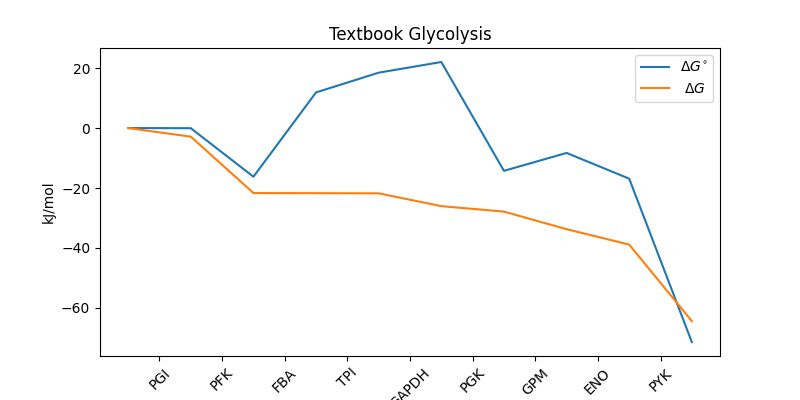

In [10]:
steps = [
    (KB('pgi'), 1),
    (KB('pfk'), 1),
    (KB('fba'), 1),
    (KB('tpi'), -1),
    (KB('gapdh'), 2),
    (KB('pgk'), -2),
    (KB('gpm'), -2),
    (KB('eno'), 2),
    (KB('pyk'), -2),
    # (KB('pdh'), 2),
]

path_dg0 = [0.] + [dgr0[step] * coeff for step, coeff in steps]
path_dg = [0.] + [dgr[step] * coeff for step, coeff in steps]

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(np.cumsum(path_dg0), label='$\Delta{G}^{\circ}$')
ax.plot(np.cumsum(path_dg), label=' $\Delta{G}$')
ax.set_xticks(np.arange(len(steps)) + 0.5, (step.label for step, _ in steps), rotation=45)
ax.set_title('Textbook Glycolysis')
ax.set_ylabel('kJ/mol')
ax.legend()
plt.show()

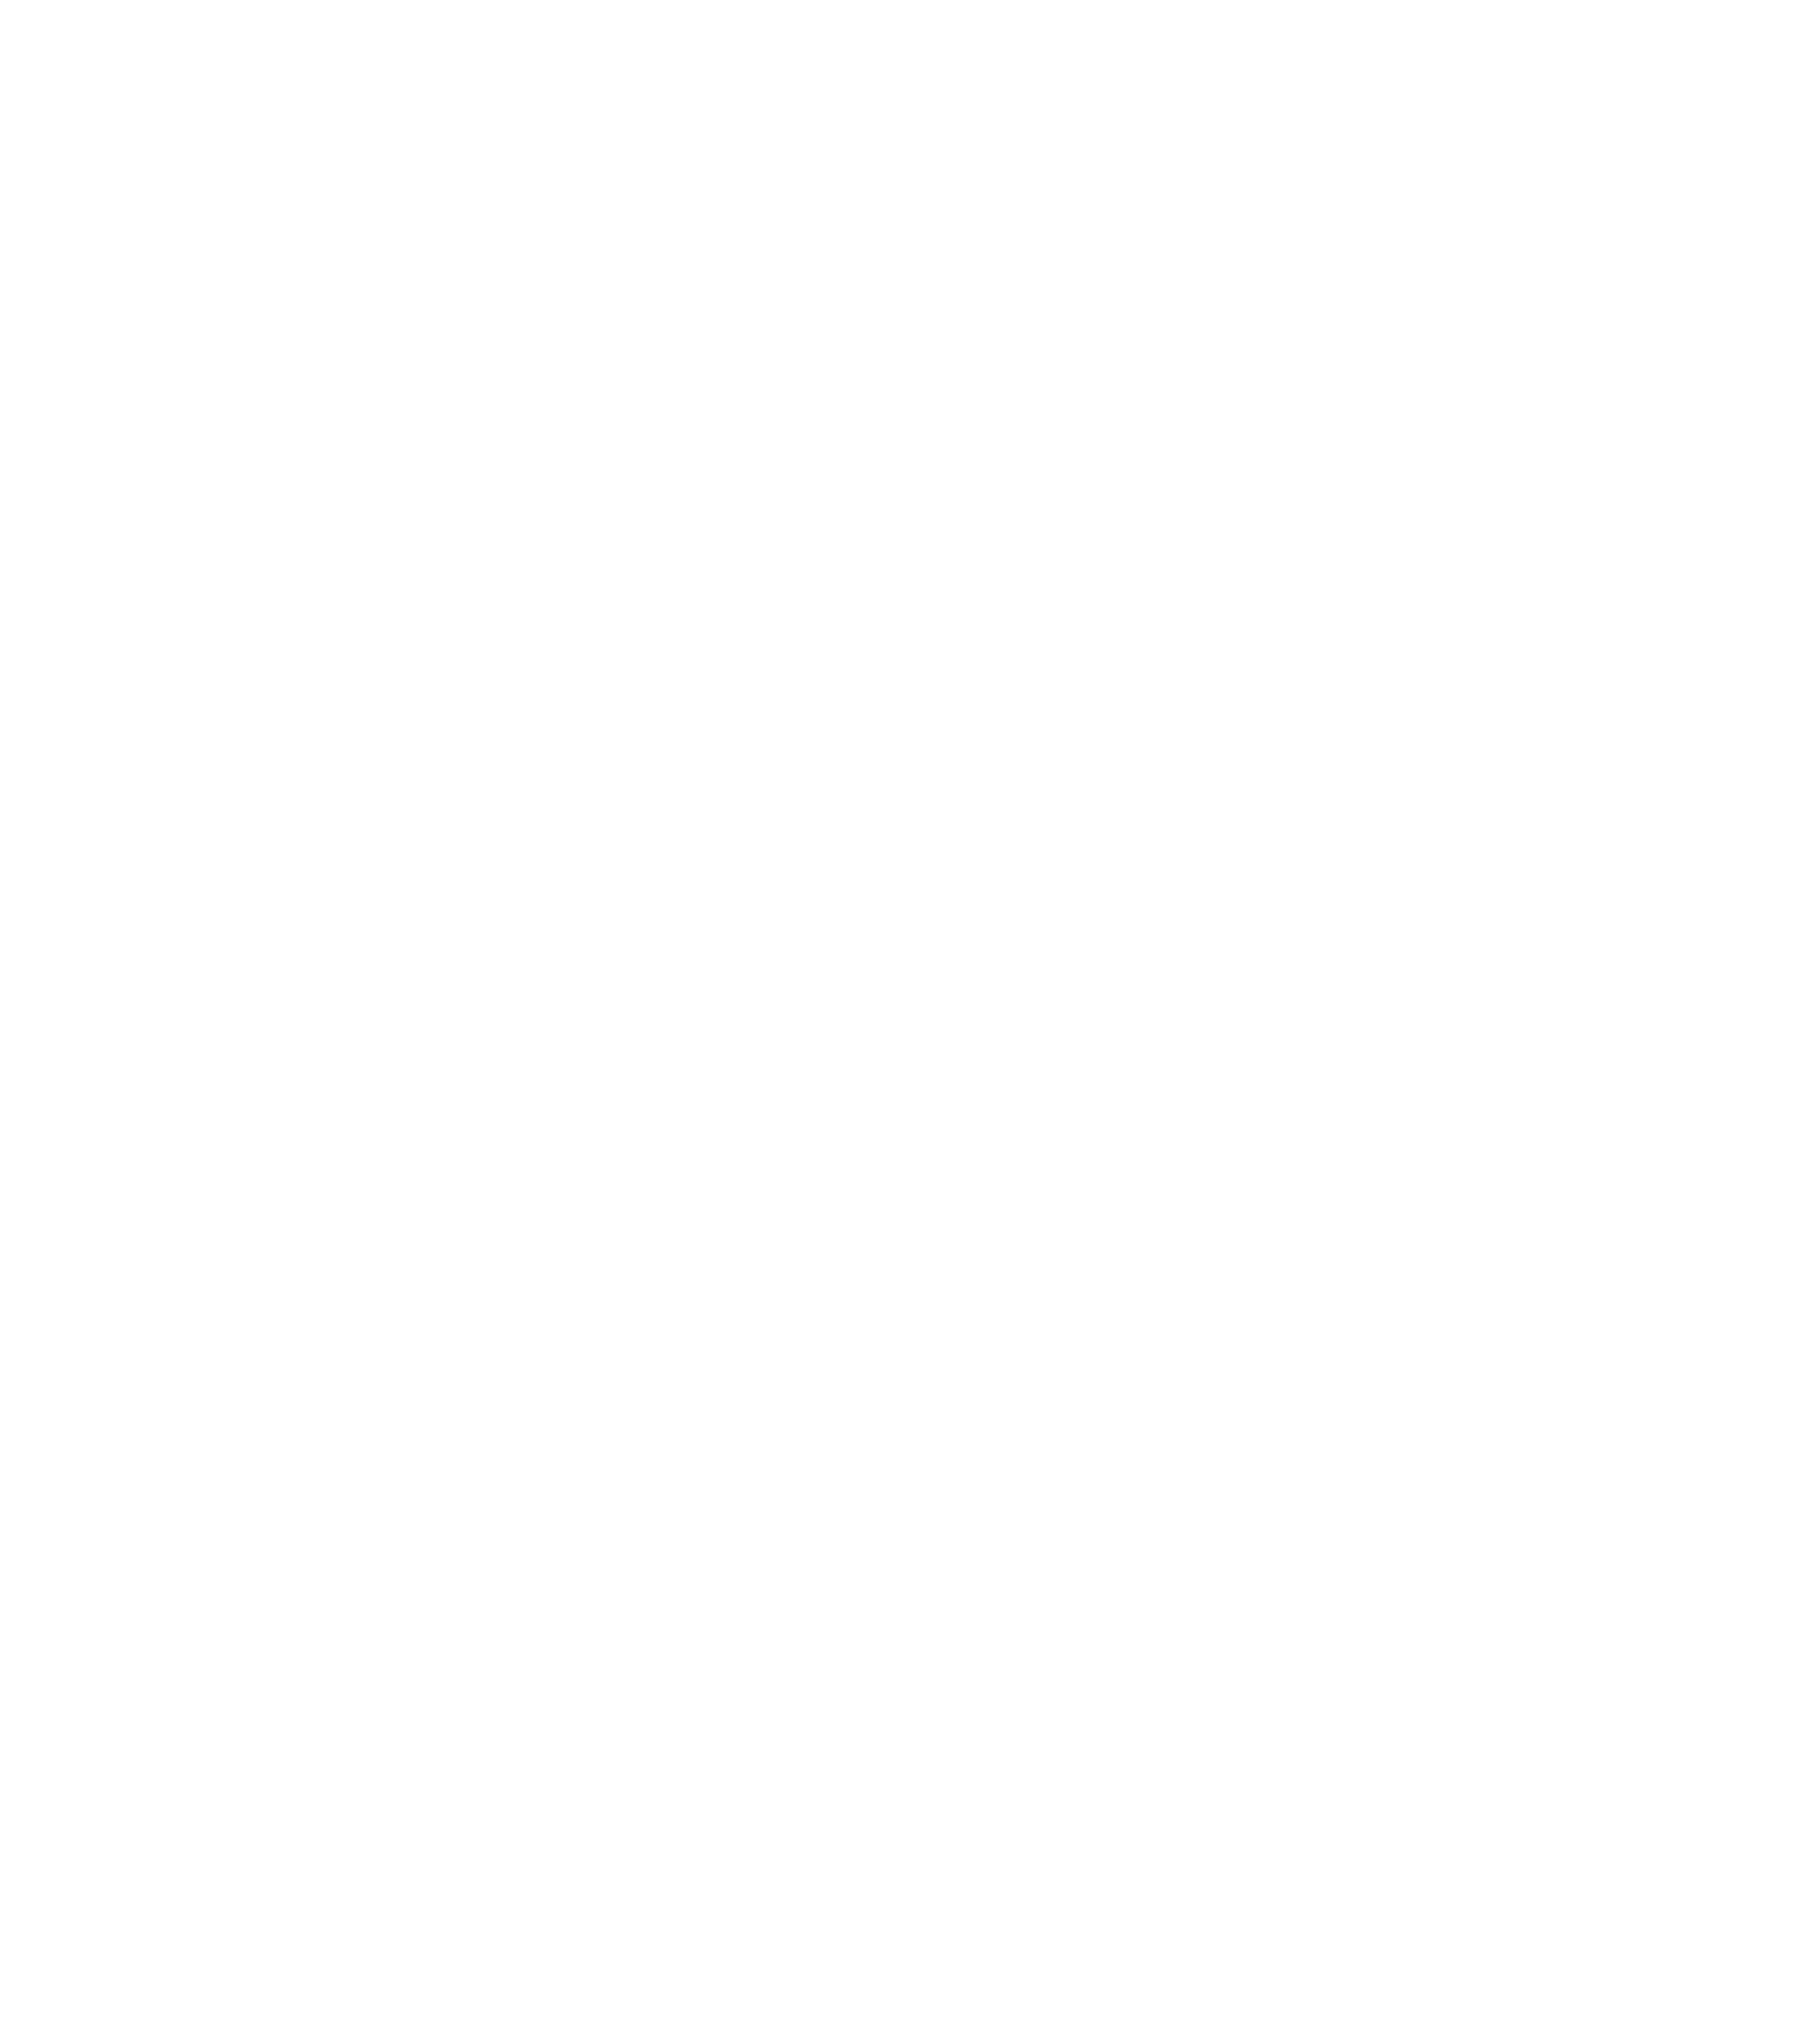

In [11]:
dg_scale = escher_map.Scale(
    stops={
        +50: ("#0000ff", 20),
        +20: ("#4444ee", 20),
        +5: ("#aaaadd", 20),
        0: ("#dddddd", 20),
        -5: ("#ddaaaa", 20),
        -20: ("#ee4444", 20),
        -50: ("#ff0000", 20),
    },
)
diag = escher_map.EscherMap(pw.diagram, width="20cm", reaction_scale=dg_scale)
SVG(diag.draw(reaction_data={k.id: -v for k, v in dgr.items()}))

### Use ΔG to constrain Elementary Modes

In [12]:
rev_threshold = 3.0
stoichiometry = []
direction = []
reversible = []
for rxn in pw.reactions:
    if abs(dgr[rxn]) <= rev_threshold:
        reversible.append(True)
        stoichiometry.append(pw.molecules.pack(rxn.stoichiometry))
        direction.append(1)
    else:
        reversible.append(False)
        if dgr[rxn] < 0:
            stoichiometry.append(pw.molecules.pack(rxn.stoichiometry))
            direction.append(1)
        else:
            stoichiometry.append(-pw.molecules.pack(rxn.stoichiometry))
            direction.append(-1)

modes, rev = elementary_modes.elementary_modes(
    np.array(stoichiometry).T[[met not in boundaries for met in pw.molecules]],
    reversible
)
modes = modes * np.array(direction).reshape(len(pw.reactions), 1)
show_modes(pw, modes, rev)